### import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Paths
DATA_RAW = Path('../data/raw')
DATA_PROCESSED = Path('../data/processed')
REPORTS_FIGURES = Path('../reports/figures')

# Create directories if needed
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

print('Setup complete')

Setup complete


### Load impact sheet from Excel

In [2]:
# Load unified data from Excel
excel_path = DATA_RAW / 'ethiopia_fi_unified_data.xlsx'

# Load main sheet
df_main = pd.read_excel(excel_path, sheet_name='ethiopia_fi_unified_data')

# Load impact sheet
df_impact = pd.read_excel(excel_path, sheet_name='Impact_sheet')

print(f'Main sheet: {len(df_main)} rows')
print(f'Impact sheet: {len(df_impact)} rows')
print(f'\nMain sheet columns: {df_main.columns.tolist()}')
print(f'\nImpact sheet columns: {df_impact.columns.tolist()}')

Main sheet: 43 rows
Impact sheet: 14 rows

Main sheet columns: ['record_id', 'record_type', 'category', 'pillar', 'indicator', 'indicator_code', 'indicator_direction', 'value_numeric', 'value_text', 'value_type', 'unit', 'observation_date', 'period_start', 'period_end', 'fiscal_year', 'gender', 'location', 'region', 'source_name', 'source_type', 'source_url', 'confidence', 'related_indicator', 'relationship_type', 'impact_direction', 'impact_magnitude', 'impact_estimate', 'lag_months', 'evidence_basis', 'comparable_country', 'collected_by', 'collection_date', 'original_text', 'notes']

Impact sheet columns: ['record_id', 'parent_id', 'record_type', 'category', 'pillar', 'indicator', 'indicator_code', 'indicator_direction', 'value_numeric', 'value_text', 'value_type', 'unit', 'observation_date', 'period_start', 'period_end', 'fiscal_year', 'gender', 'location', 'region', 'source_name', 'source_type', 'source_url', 'confidence', 'related_indicator', 'relationship_type', 'impact_direction

###   Build Event Catalog

In [3]:
# Filter events from main sheet
events = df_main[df_main['record_type'] == 'event'].copy()

# Determine date column (Excel schema uses observation_date for events)
if 'event_date' in events.columns and events['event_date'].notna().any():
    date_col = 'event_date'
else:
    date_col = 'observation_date'

# Parse dates
events[date_col] = pd.to_datetime(events[date_col], format='mixed', errors='coerce')

# Create clean event catalog
event_catalog = events[['record_id', 'indicator', 'category', date_col]].copy()
event_catalog.columns = ['event_id', 'event_name', 'event_category', 'event_date']

print(f'Event catalog: {len(event_catalog)} events')
print(f'\nEvent categories:')
print(event_catalog['event_category'].value_counts())
print(f'\nEvents with valid dates: {event_catalog["event_date"].notna().sum()}')
print(f'\nEvent Catalog:')
event_catalog

Event catalog: 10 events

Event categories:
event_category
product_launch    2
infrastructure    2
policy            2
market_entry      1
milestone         1
partnership       1
pricing           1
Name: count, dtype: int64

Events with valid dates: 10

Event Catalog:


,event_id,event_name,event_category,event_date
33,EVT_0001,Telebirr Launch,product_launch,2021-05-17
34,EVT_0002,Safaricom Ethiopia Commercial Launch,market_entry,2022-08-01
35,EVT_0003,M-Pesa Ethiopia Launch,product_launch,2023-08-01
36,EVT_0004,Fayda Digital ID Program Rollout,infrastructure,2024-01-01
37,EVT_0005,Foreign Exchange Liberalization,policy,2024-07-29
38,EVT_0006,P2P Transaction Count Surpasses ATM,milestone,2024-10-01
39,EVT_0007,M-Pesa EthSwitch Integration,partnership,2025-10-27
40,EVT_0008,EthioPay Instant Payment System Launch,infrastructure,2025-12-18
41,EVT_0009,NFIS-II Strategy Launch,policy,2021-09-01
42,EVT_0010,Safaricom Ethiopia Price Increase,pricing,2025-12-15


### Process Impact Links

In [4]:

# Filter impact_link records
# Impact links may be in the Impact_sheet or in main sheet with record_type == 'impact_link'
if 'record_type' in df_impact.columns:
    impact_links = df_impact[df_impact['record_type'] == 'impact_link'].copy()
else:
    # Assume entire Impact_sheet contains impact links
    impact_links = df_impact.copy()

# Also check main sheet for impact_link records
main_impact_links = df_main[df_main['record_type'] == 'impact_link'].copy()
if not main_impact_links.empty:
    # Combine if both exist
    impact_links = pd.concat([impact_links, main_impact_links], ignore_index=True)

print(f'Total impact links: {len(impact_links)}')

# Select relevant columns (handle missing columns gracefully)
link_cols = ['record_id', 'parent_id', 'pillar', 'related_indicator', 
             'impact_direction', 'impact_magnitude', 'impact_estimate', 
             'lag_months', 'evidence_basis']
available_cols = [c for c in link_cols if c in impact_links.columns]
impact_links = impact_links[available_cols].copy()

# Fill missing lag_months with 0
if 'lag_months' in impact_links.columns:
    impact_links['lag_months'] = impact_links['lag_months'].fillna(0).astype(int)
else:
    impact_links['lag_months'] = 0

# Validate parent_id exists in event catalog
valid_events = set(event_catalog['event_id'])
impact_links['valid_parent'] = impact_links['parent_id'].isin(valid_events)
print(f'Impact links with valid parent event: {impact_links["valid_parent"].sum()}')

# Merge with event info
impact_links = impact_links.merge(
    event_catalog[['event_id', 'event_name', 'event_category', 'event_date']],
    left_on='parent_id',
    right_on='event_id',
    how='left'
)

print(f'\nImpact links sample:')
impact_links.head(10)

Total impact links: 14
Impact links with valid parent event: 14

Impact links sample:


,record_id,parent_id,pillar,related_indicator,impact_direction,impact_magnitude,impact_estimate,lag_months,evidence_basis,valid_parent,event_id,event_name,event_category,event_date
0,IMP_0001,EVT_0001,ACCESS,ACC_OWNERSHIP,increase,high,15.0,12,literature,True,EVT_0001,Telebirr Launch,product_launch,2021-05-17
1,IMP_0002,EVT_0001,USAGE,USG_TELEBIRR_USERS,increase,high,NaN,3,empirical,True,EVT_0001,Telebirr Launch,product_launch,2021-05-17
2,IMP_0003,EVT_0001,USAGE,USG_P2P_COUNT,increase,high,25.0,6,empirical,True,EVT_0001,Telebirr Launch,product_launch,2021-05-17
3,IMP_0004,EVT_0002,ACCESS,ACC_4G_COV,increase,medium,15.0,12,empirical,True,EVT_0002,Safaricom Ethiopia Commercial Launch,market_entry,2022-08-01
4,IMP_0005,EVT_0002,AFFORDABILITY,AFF_DATA_INCOME,decrease,medium,-20.0,12,literature,True,EVT_0002,Safaricom Ethiopia Commercial Launch,market_entry,2022-08-01
5,IMP_0006,EVT_0003,USAGE,USG_MPESA_USERS,increase,high,NaN,3,empirical,True,EVT_0003,M-Pesa Ethiopia Launch,product_launch,2023-08-01
6,IMP_0007,EVT_0003,ACCESS,ACC_MM_ACCOUNT,increase,medium,5.0,6,theoretical,True,EVT_0003,M-Pesa Ethiopia Launch,product_launch,2023-08-01
7,IMP_0008,EVT_0004,ACCESS,ACC_OWNERSHIP,increase,medium,10.0,24,literature,True,EVT_0004,Fayda Digital ID Program Rollout,infrastructure,2024-01-01
8,IMP_0009,EVT_0004,GENDER,GEN_GAP_ACC,decrease,medium,-5.0,24,literature,True,EVT_0004,Fayda Digital ID Program Rollout,infrastructure,2024-01-01
9,IMP_0010,EVT_0005,AFFORDABILITY,AFF_DATA_INCOME,increase,high,30.0,3,empirical,True,EVT_0005,Foreign Exchange Liberalization,policy,2024-07-29


### Create Event–Indicator Association Matrix

In [5]:

# Define magnitude mapping (if no numeric impact_estimate)
MAGNITUDE_MAP = {
    'low': 0.25,
    'medium': 0.5,
    'high': 1.0,
    'very_high': 1.5
}

DIRECTION_MAP = {
    'increase': 1,
    'positive': 1,
    'decrease': -1,
    'negative': -1,
    'neutral': 0,
    'mixed': 0.5
}

def compute_impact_weight(row):
    """Compute numeric impact weight from magnitude and direction."""
    # Use impact_estimate if available
    if 'impact_estimate' in row.index and pd.notna(row.get('impact_estimate')):
        return float(row['impact_estimate'])
    
    # Otherwise compute from magnitude and direction
    magnitude = row.get('impact_magnitude', 'medium')
    direction = row.get('impact_direction', 'increase')
    
    if pd.isna(magnitude):
        magnitude = 'medium'
    if pd.isna(direction):
        direction = 'increase'
    
    mag_val = MAGNITUDE_MAP.get(str(magnitude).lower(), 0.5)
    dir_val = DIRECTION_MAP.get(str(direction).lower(), 1)
    
    return mag_val * dir_val

# Compute weights
impact_links['impact_weight'] = impact_links.apply(compute_impact_weight, axis=1)

print('Impact weights computed')
impact_links[['event_name', 'pillar', 'related_indicator', 'impact_direction', 'impact_magnitude', 'impact_weight']].head(10)

Impact weights computed


,event_name,pillar,related_indicator,impact_direction,impact_magnitude,impact_weight
0,Telebirr Launch,ACCESS,ACC_OWNERSHIP,increase,high,15.0
1,Telebirr Launch,USAGE,USG_TELEBIRR_USERS,increase,high,1.0
2,Telebirr Launch,USAGE,USG_P2P_COUNT,increase,high,25.0
3,Safaricom Ethiopia Commercial Launch,ACCESS,ACC_4G_COV,increase,medium,15.0
4,Safaricom Ethiopia Commercial Launch,AFFORDABILITY,AFF_DATA_INCOME,decrease,medium,-20.0
5,M-Pesa Ethiopia Launch,USAGE,USG_MPESA_USERS,increase,high,1.0
6,M-Pesa Ethiopia Launch,ACCESS,ACC_MM_ACCOUNT,increase,medium,5.0
7,Fayda Digital ID Program Rollout,ACCESS,ACC_OWNERSHIP,increase,medium,10.0
8,Fayda Digital ID Program Rollout,GENDER,GEN_GAP_ACC,decrease,medium,-5.0
9,Foreign Exchange Liberalization,AFFORDABILITY,AFF_DATA_INCOME,increase,high,30.0


### Build Event-Indicator matrix

In [6]:
# Build Event-Indicator matrix
# Pivot: rows = events, columns = indicators, values = impact_weight

# Get unique indicators impacted
if 'related_indicator' in impact_links.columns:
    indicator_col = 'related_indicator'
else:
    indicator_col = 'pillar'  # fallback

# Create pivot table
event_indicator_matrix = impact_links.pivot_table(
    index=['event_name', 'event_category'],
    columns=indicator_col,
    values='impact_weight',
    aggfunc='sum',
    fill_value=0
)

print(f'Event-Indicator Matrix shape: {event_indicator_matrix.shape}')
event_indicator_matrix

Event-Indicator Matrix shape: (8, 9)


,related_indicator,ACC_4G_COV,ACC_MM_ACCOUNT,ACC_OWNERSHIP,AFF_DATA_INCOME,GEN_GAP_ACC,USG_MPESA_ACTIVE,USG_MPESA_USERS,USG_P2P_COUNT,USG_TELEBIRR_USERS
event_name,event_category,,,,,,,,,
EthioPay Instant Payment System Launch,infrastructure,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0
Fayda Digital ID Program Rollout,infrastructure,0.0,0.0,10.0,0.0,-5.0,0.0,0.0,0.0,0.0
Foreign Exchange Liberalization,policy,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0
M-Pesa EthSwitch Integration,partnership,0.0,0.0,0.0,0.0,0.0,15.0,0.0,10.0,0.0
M-Pesa Ethiopia Launch,product_launch,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Safaricom Ethiopia Commercial Launch,market_entry,15.0,0.0,0.0,-20.0,0.0,0.0,0.0,0.0,0.0
Safaricom Ethiopia Price Increase,pricing,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0
Telebirr Launch,product_launch,0.0,0.0,15.0,0.0,0.0,0.0,0.0,25.0,1.0


### Visualize Event-Indicator Matrix as heatmap

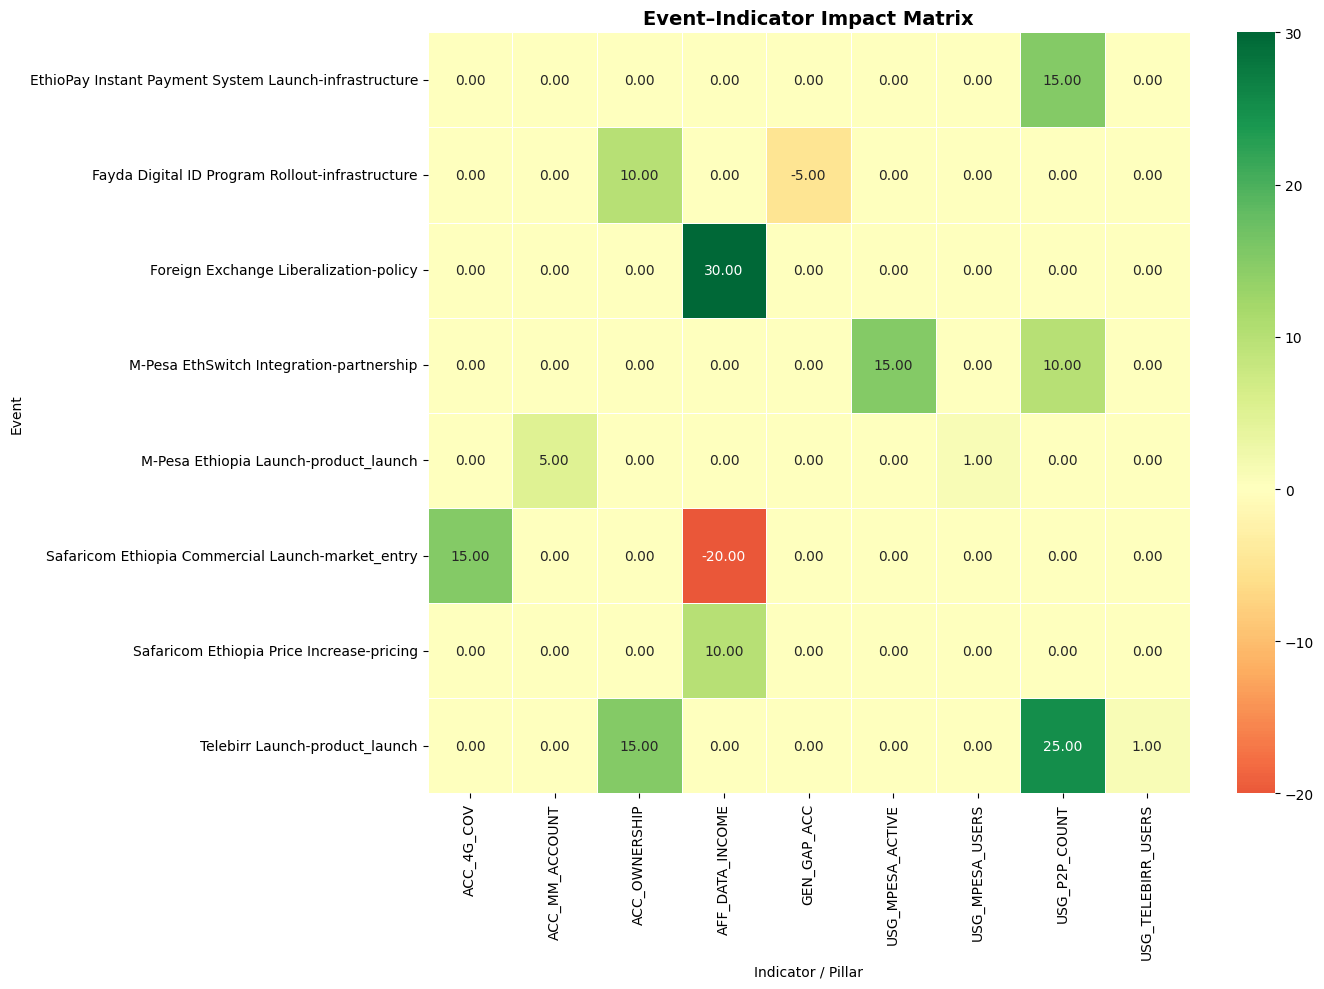

Saved: ..\reports\figures\event_indicator_matrix.png


In [7]:
# Visualize Event-Indicator Matrix as heatmap
fig, ax = plt.subplots(figsize=(14, 10))

sns.heatmap(
    event_indicator_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn',
    center=0,
    linewidths=0.5,
    ax=ax
)

ax.set_title('Event–Indicator Impact Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Indicator / Pillar')
ax.set_ylabel('Event')

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / 'event_indicator_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Saved: {REPORTS_FIGURES / "event_indicator_matrix.png"}')

In [8]:
# Save matrix to CSV
event_indicator_matrix.to_csv(DATA_PROCESSED / 'event_indicator_matrix.csv')
print(f'Saved: {DATA_PROCESSED / "event_indicator_matrix.csv"}')

Saved: ..\data\processed\event_indicator_matrix.csv


### Generate Time-Series Intervention Features

In [9]:
# Create monthly time index from earliest observation to 2027-12-31
observations = df_main[df_main['record_type'] == 'observation'].copy()
observations['observation_date'] = pd.to_datetime(observations['observation_date'], format='mixed', errors='coerce')

min_date = observations['observation_date'].min()
max_date = pd.Timestamp('2027-12-31')

# Monthly time index
time_index = pd.date_range(start=min_date.replace(day=1), end=max_date, freq='MS')
print(f'Time index: {time_index[0]} to {time_index[-1]} ({len(time_index)} months)')

Time index: 2014-12-01 00:00:00 to 2027-12-01 00:00:00 (157 months)


In [10]:

def create_intervention_feature(event_date, lag_months, time_index, ramp_months=6):
    """
    Create intervention feature with lag and ramp.
    
    Args:
        event_date: When event occurred
        lag_months: Months before effect starts
        time_index: DatetimeIndex of time points
        ramp_months: Months for effect to reach full strength
    
    Returns:
        Series with intervention effect (0 to 1)
    """
    if pd.isna(event_date):
        return pd.Series(0, index=time_index)
    
    # Effect start date
    effect_start = event_date + pd.DateOffset(months=int(lag_months))
    
    # Create feature
    feature = pd.Series(0.0, index=time_index)
    
    for i, t in enumerate(time_index):
        if t < effect_start:
            feature.iloc[i] = 0.0
        else:
            months_since_start = (t.year - effect_start.year) * 12 + (t.month - effect_start.month)
            if ramp_months > 0:
                feature.iloc[i] = min(1.0, months_since_start / ramp_months)
            else:
                feature.iloc[i] = 1.0
    
    return feature

# Test
test_feature = create_intervention_feature(pd.Timestamp('2021-05-01'), 3, time_index)
print('Test intervention feature (sample):')
print(test_feature[test_feature > 0].head(10))

Test intervention feature (sample):
2021-09-01    0.166667
2021-10-01    0.333333
2021-11-01    0.500000
2021-12-01    0.666667
2022-01-01    0.833333
2022-02-01    1.000000
2022-03-01    1.000000
2022-04-01    1.000000
2022-05-01    1.000000
2022-06-01    1.000000
Freq: MS, dtype: float64


In [11]:
# Build event features dataframe
event_features = pd.DataFrame(index=time_index)
event_features.index.name = 'date'

# Key indicators to model
KEY_INDICATORS = ['ACC_OWNERSHIP', 'ACC_MM_ACCOUNT', 'USG_DIGITAL_PAYMENT', 'USG_P2P_VOLUME']
KEY_PILLARS = ['ACCESS', 'USAGE']

# Initialize aggregated effect columns
for indicator in KEY_INDICATORS:
    event_features[f'event_effect_{indicator}'] = 0.0

for pillar in KEY_PILLARS:
    event_features[f'event_effect_{pillar}'] = 0.0

# Process each impact link
for _, link in impact_links.iterrows():
    event_date = link.get('event_date')
    lag = link.get('lag_months', 0)
    weight = link.get('impact_weight', 0)
    indicator = link.get('related_indicator', '')
    pillar = link.get('pillar', '')
    
    if pd.isna(event_date) or weight == 0:
        continue
    
    # Create intervention feature
    intervention = create_intervention_feature(event_date, lag, time_index)
    
    # Add weighted effect to indicator column
    if indicator in KEY_INDICATORS:
        event_features[f'event_effect_{indicator}'] += weight * intervention
    
    # Add to pillar aggregation
    if pillar in KEY_PILLARS:
        event_features[f'event_effect_{pillar}'] += weight * intervention

print(f'Event features shape: {event_features.shape}')
print(f'\nColumns: {event_features.columns.tolist()}')


Event features shape: (157, 6)

Columns: ['event_effect_ACC_OWNERSHIP', 'event_effect_ACC_MM_ACCOUNT', 'event_effect_USG_DIGITAL_PAYMENT', 'event_effect_USG_P2P_VOLUME', 'event_effect_ACCESS', 'event_effect_USAGE']


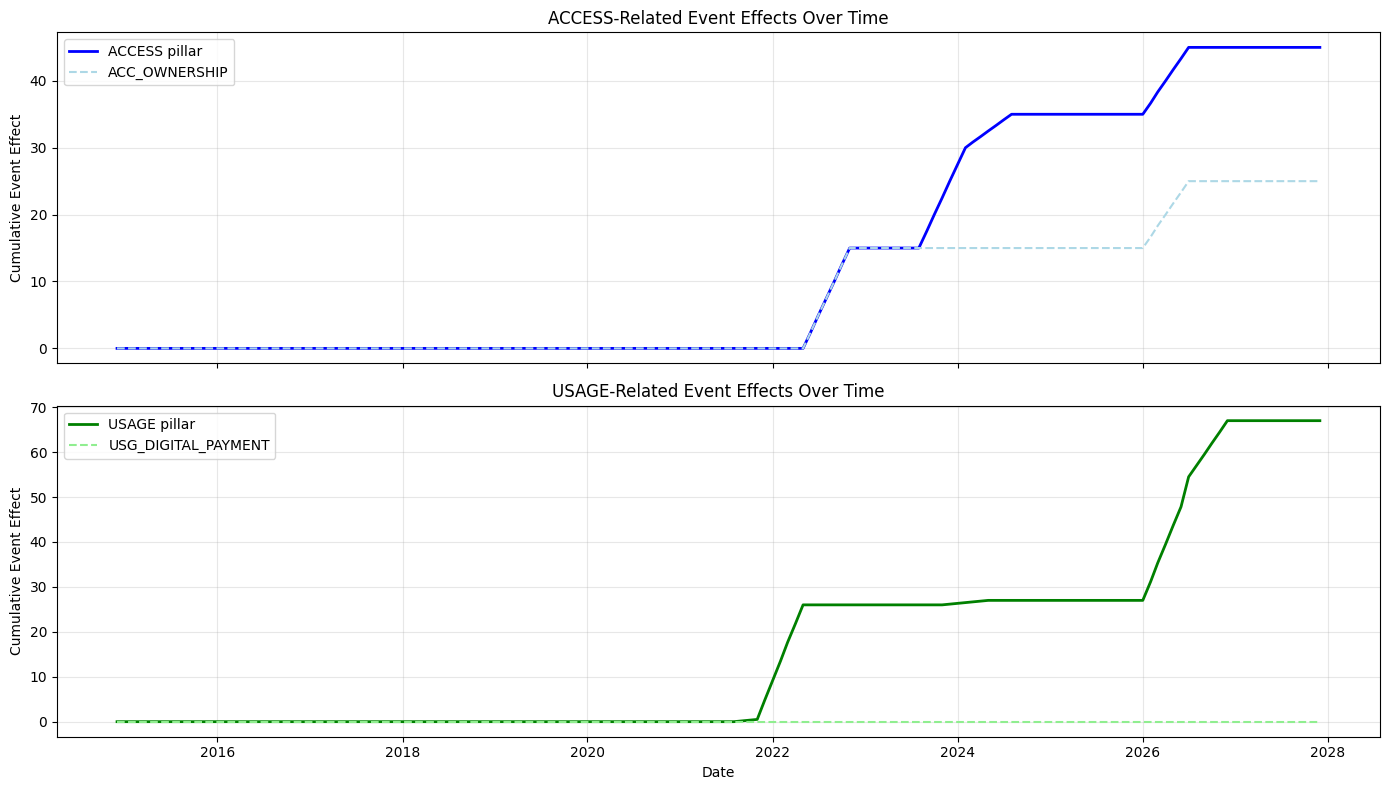

Saved: ..\reports\figures\event_effects_timeline.png


In [12]:
# Visualize event effects over time
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# ACCESS effects
ax1 = axes[0]
ax1.plot(event_features.index, event_features['event_effect_ACCESS'], 
         color='blue', linewidth=2, label='ACCESS pillar')
if 'event_effect_ACC_OWNERSHIP' in event_features.columns:
    ax1.plot(event_features.index, event_features['event_effect_ACC_OWNERSHIP'], 
             color='lightblue', linestyle='--', label='ACC_OWNERSHIP')
ax1.set_ylabel('Cumulative Event Effect')
ax1.set_title('ACCESS-Related Event Effects Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# USAGE effects
ax2 = axes[1]
ax2.plot(event_features.index, event_features['event_effect_USAGE'], 
         color='green', linewidth=2, label='USAGE pillar')
if 'event_effect_USG_DIGITAL_PAYMENT' in event_features.columns:
    ax2.plot(event_features.index, event_features['event_effect_USG_DIGITAL_PAYMENT'], 
             color='lightgreen', linestyle='--', label='USG_DIGITAL_PAYMENT')
ax2.set_ylabel('Cumulative Event Effect')
ax2.set_xlabel('Date')
ax2.set_title('USAGE-Related Event Effects Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(REPORTS_FIGURES / 'event_effects_timeline.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Saved: {REPORTS_FIGURES / "event_effects_timeline.png"}')

In [13]:
# Save event features
event_features.to_csv(DATA_PROCESSED / 'event_features.csv')
print(f'Saved: {DATA_PROCESSED / "event_features.csv"}')

Saved: ..\data\processed\event_features.csv


### Validate Impacts Against History

In [14]:
# Load observations for validation
acc_ownership = observations[observations['indicator_code'] == 'ACC_OWNERSHIP'].copy()
acc_ownership = acc_ownership.sort_values('observation_date')

mm_accounts = observations[observations['indicator_code'] == 'ACC_MM_ACCOUNT'].copy()
mm_accounts = mm_accounts.sort_values('observation_date')

print('=== VALIDATION: Telebirr Launch Impact ===')
print('\nTelebirr launched May 2021')

# Check mobile money accounts before/after
if not mm_accounts.empty:
    pre_telebirr = mm_accounts[mm_accounts['observation_date'] < '2021-05-01']
    post_telebirr = mm_accounts[mm_accounts['observation_date'] >= '2021-05-01']
    
    if not pre_telebirr.empty and not post_telebirr.empty:
        pre_val = pre_telebirr['value_numeric'].iloc[-1]
        post_val = post_telebirr['value_numeric'].iloc[-1]
        print(f'Mobile money accounts pre-Telebirr: {pre_val:.1f}%')
        print(f'Mobile money accounts post-Telebirr: {post_val:.1f}%')
        print(f'Change: +{post_val - pre_val:.1f}pp')
        print('✓ Positive direction aligns with modeled impact')
    else:
        print('Limited data for before/after comparison')
        if not mm_accounts.empty:
            print(f'Latest MM account ownership: {mm_accounts["value_numeric"].iloc[-1]:.1f}%')

print('\n=== VALIDATION: Overall Account Ownership Trend ===')
if len(acc_ownership) >= 2:
    for i, row in acc_ownership.iterrows():
        date_str = row['observation_date'].strftime('%Y') if pd.notna(row['observation_date']) else 'Unknown'
        print(f"{date_str}: {row['value_numeric']:.1f}%")

=== VALIDATION: Telebirr Launch Impact ===

Telebirr launched May 2021
Limited data for before/after comparison
Latest MM account ownership: 9.4%

=== VALIDATION: Overall Account Ownership Trend ===
2014: 22.0%
2017: 35.0%
2021: 46.0%
2021: 56.0%
2021: 36.0%
2024: 49.0%


In [15]:
# Check consistency constraints
print('=== CONSISTENCY CHECKS ===')

# All event effects should be reasonable
max_access_effect = event_features['event_effect_ACCESS'].max()
max_usage_effect = event_features['event_effect_USAGE'].max()

print(f'Max cumulative ACCESS effect: {max_access_effect:.2f}')
print(f'Max cumulative USAGE effect: {max_usage_effect:.2f}')

# Warn if effects seem too large
if max_access_effect > 50:
    print('⚠ ACCESS effect may be too large - consider capping or re-weighting')
else:
    print('✓ ACCESS effect magnitude reasonable')

if max_usage_effect > 50:
    print('⚠ USAGE effect may be too large - consider capping or re-weighting')
else:
    print('✓ USAGE effect magnitude reasonable')

=== CONSISTENCY CHECKS ===
Max cumulative ACCESS effect: 45.00
Max cumulative USAGE effect: 67.00
✓ ACCESS effect magnitude reasonable
⚠ USAGE effect may be too large - consider capping or re-weighting


### Summary & Methodology Documentation

In [16]:
print('=== TASK 3 COMPLETE ===')
print(f'\nOutputs generated:')
print(f'  - {DATA_PROCESSED / "event_indicator_matrix.csv"}')
print(f'  - {DATA_PROCESSED / "event_features.csv"}')
print(f'  - {REPORTS_FIGURES / "event_indicator_matrix.png"}')
print(f'  - {REPORTS_FIGURES / "event_effects_timeline.png"}')
print(f'  - reports/task3_methodology.md')

=== TASK 3 COMPLETE ===

Outputs generated:
  - ..\data\processed\event_indicator_matrix.csv
  - ..\data\processed\event_features.csv
  - ..\reports\figures\event_indicator_matrix.png
  - ..\reports\figures\event_effects_timeline.png
  - reports/task3_methodology.md
